In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras import Sequential, Model
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import os
from data import dnn_input
from model.RandomKernelModel import RandomKernelModel
from data import classifier_input
from sklearn.linear_model import RidgeClassifierCV
from sklearn.decomposition import KernelPCA
from sklearn.externals import joblib
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Data generation

In [2]:
train_data = dnn_input.get_processed_frames(os.path.abspath('./data/videos/frames_train/'))
test_data = dnn_input.get_processed_frames(os.path.abspath('./data/videos/frames_test/'))


## Model

In [3]:
model = RandomKernelModel.build_model((240, 320, 6),(10, 4), kernel_count=400)
# model.save_weights('./checkpoints/saved_model')
model.load_weights('./checkpoints/saved_model')

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 240, 320, 6) 0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 240, 320, 6) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 240, 320, 400 240400      input_1[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 10, 4)]      0                                        

In [ ]:
output_train = model.predict(train_data, batch_size=16)

In [ ]:
output_test = model.predict(test_data, batch_size=16)

## Generate dataset for classification

In [ ]:
X_train, y_train = classifier_input.get_processed_classifier_input(output_train, normalized=True)
X_test, y_test = classifier_input.get_processed_classifier_input(output_test, normalized=True)
X_test_proper, y_test_proper = classifier_input.get_processed_classifier_input(output_test, normalized=True, balanced=False)

In [ ]:
X_test_proper = np.asarray(X_test_proper)
y_test_proper = np.asarray(y_test_proper)

In [ ]:
a, b = np.unique(y_test_proper, return_counts=True)

In [ ]:
print(a)
print(b)

In [ ]:
np.save('X_train', X_train)
np.save('y_train', y_train)
np.save('X_test', X_test)
np.save('y_test', y_test)
np.save('X_test_proper', X_test_proper)
np.save('y_test_proper', y_test_proper)

In [5]:
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
X_test_proper = np.load('X_test_proper.npy')
y_test_proper = np.load('y_test_proper.npy')

In [6]:
X_train.shape

(8280, 3200)

## Dimensionality reduction

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100, whiten = False, random_state = 2019)
# pca = KernelPCA(kernel="rbf",n_components=154, gamma=None, fit_inverse_transform=True, random_state = 2019, n_jobs=1)

X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)
X_pca_test_proper = pca.transform(X_test_proper)
# X_pca_reconst = pca.inverse_transform(X_pca)

In [8]:
joblib.dump(pca, './checkpoints/pca.joblib.pkl', 9)

['./checkpoints/pca.joblib.pkl']

In [9]:
a,b = np.unique(y_train, return_counts=True)
print(a)
print(b)

[0 1]
[4140 4140]


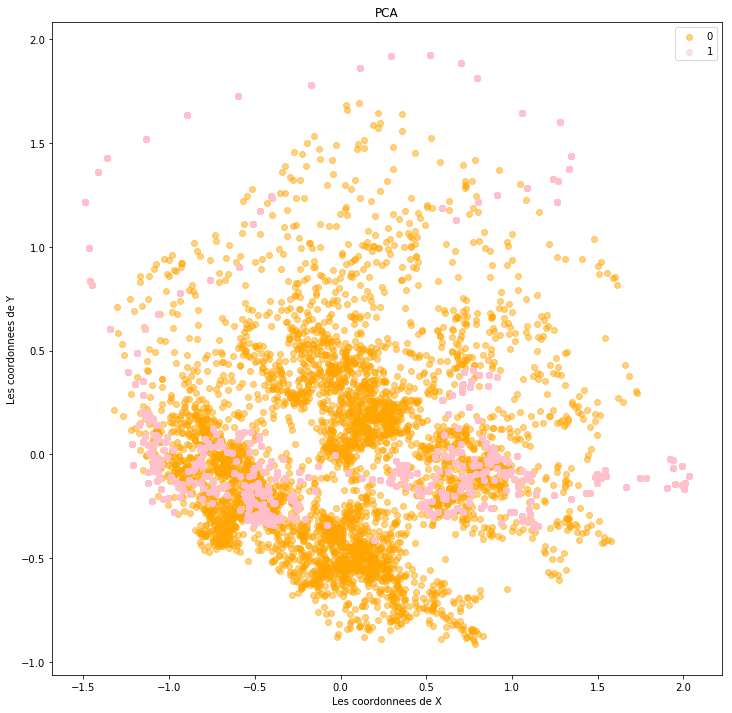

In [10]:
plt.figure(figsize=(12,12))

plt.scatter(X_pca_train[y_train==0, 0], X_pca_train[y_train==0, 1], color='orange', alpha=0.5,label='0')
plt.scatter(X_pca_train[y_train==1, 0], X_pca_train[y_train==1, 1], color='pink', alpha=0.5,label='1')
plt.title("PCA")
plt.ylabel('Les coordonnees de Y')
plt.xlabel('Les coordonnees de X')
plt.legend()
plt.show()

## SVM classifier

In [11]:
from sklearn.svm import SVC

In [12]:
clf = SVC(gamma='auto')

In [13]:
clf.fit(X_pca_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [14]:
print(clf.score(X_pca_test,y_test))
y = clf.predict(X_pca_test)
a, b = np.unique(y, return_counts=True)
print(a)
print(b)

0.5678743961352657
[0 1]
[3964 4316]


## Advanced SVM

## Ridge Classifier

In [ ]:
classifier = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10), normalize = True)

In [ ]:
classifier.fit(X_pca_train, y_train)

In [ ]:
classifier.score(X_pca_test, y_test)

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=0)
clf.fit(X_pca_train, y_train)

In [ ]:
clf.score(X_pca_test, y_test)

In [ ]:
print(clf.score(X_pca_test,y_test))
y = clf.predict(X_pca_test)
a, b = np.unique(y, return_counts=True)
print(a)
print(b)

In [ ]:
print(clf.score(X_pca_test_proper, y_test_proper))
y_predict_proper = clf.predict(X_pca_test_proper)

In [ ]:
a,b = np.unique(y_test_proper, return_counts=True)
print(a)
print(b)

In [ ]:
a,b = np.unique(y_predict_proper, return_counts=True)
print(a)
print(b)

## Gradient boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
clf = GradientBoostingClassifier(n_estimators=200, max_depth=7, random_state=0)
clf.fit(X_pca_train, y_train)
clf.score(X_pca_test, y_test)

In [ ]:
print(clf.score(X_pca_test_proper, y_test_proper))
y_predict_proper = clf.predict(X_pca_test_proper)
a,b = np.unique(y_predict_proper, return_counts=True)
print(a)
print(b)

## Ada boost classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
clf = AdaBoostClassifier()
clf.fit(X_pca_train, y_train)
clf.score(X_pca_test, y_test)

In [ ]:
print(clf.score(X_pca_test_proper, y_test_proper))
y_predict_proper = clf.predict(X_pca_test_proper)
a,b = np.unique(y_predict_proper, return_counts=True)
print(a)
print(b)

## Evaluations

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score

data = confusion_matrix(y_test_proper, y_predict_proper)

In [ ]:
data

In [ ]:
precision, recall, _, _ = precision_recall_fscore_support(y_test_proper, y_predict_proper, average='binary')
f1 = f1_score(y_test_proper, y_predict_proper)
print(precision)
print(recall)
print(f1)

In [ ]:
df_cm = pd.DataFrame(data, columns=np.unique(y_test_proper), index = np.unique(y_test_proper))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

In [ ]:
joblib.dump(clf, './checkpoints/classifier.joblib.pkl', compress=9)

In [ ]:
clf2 = joblib.load('./checkpoints/random_forest_classifier.joblib.pkl')